# (Back) tracking particles in the geomagnetic field

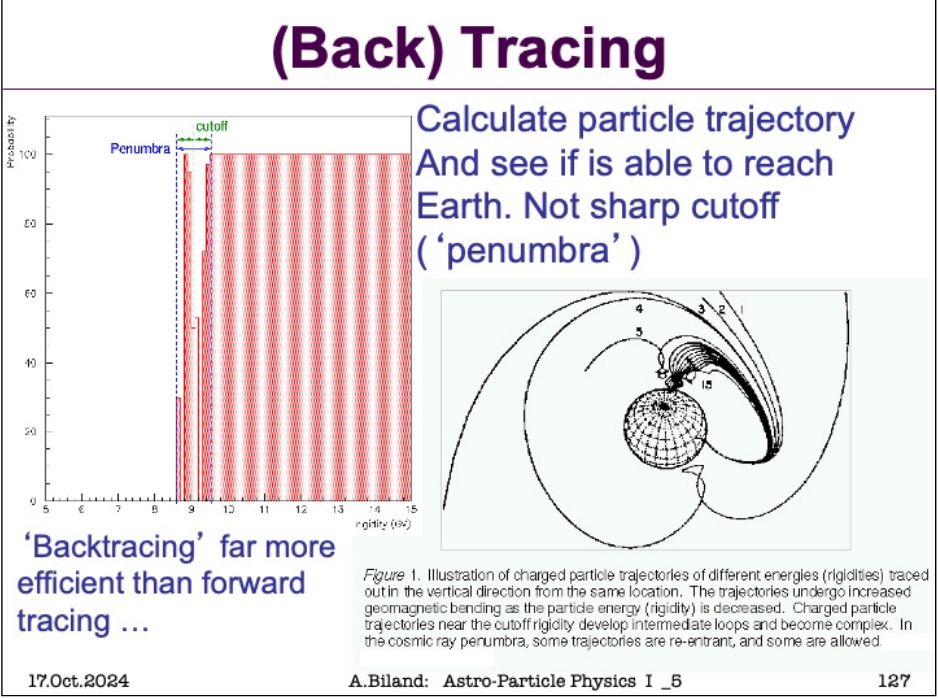

Following the papers:
- Soni, Kakad, Kakad - https://doi.org/10.1016/j.asr.2020.10.020
- Öztürk - https://doi.org/10.1119/1.3684537


Notebook available under:
https://gitlab.ethz.ch/remoll/app-gbt

In [1]:
import numpy as np
import scipy.integrate as spi
import matplotlib.pyplot as plt
from astropy import units as u
from astropy import constants as c
from astropy.coordinates import EarthLocation
from astropy.time import Time

from datetime import datetime
import ppigrf

DEBUG = None # to be set later

#### Tracking a single proton

In [2]:
## Some constants
# Single proton mass & charge
MASS = c.m_p
CHARGE = c.e.si

# somewhat arbitrary date
DATE = datetime(2021, 3, 28)
obstime = Time("2021-03-28T12:00:00", scale='utc')

ABSOLUTE_TOLERANCE = 1e5

### Modelling the magnetic field
- As a sanity check we can use a simple homogeneous magnetic field in the z direction
$$
\mathbf{B} = B_0 \mathbf{e}_z
$$
- In the simplest approximation, the magnetic field can be modelled as a **dipole field**. In cartesian coordinates, it is given by (Griffiths):
$$
\mathbf{B}(\mathbf{r}) = -B_0 \cdot \frac{R_{earth}^3}{r^5} * \left( 3xz \cdot \mathbf{e_x} + 3yz\cdot \mathbf{e_y} + (2z^2 - x^2 - y^2)\cdot \mathbf{e_z}\right)
$$ 
- A better approximation is given by the **IGRF model**.
    - sum of spherical harmonics. (The coefficients are fitted to measurements)
    - accounts for time variations


In [3]:
## helpers for IGRF, since it is given in spherical coordinates
def cartesian_to_spherical(v: np.ndarray) -> np.ndarray:
    return np.array([
        np.linalg.norm(v),
        np.degrees(np.arctan2(np.linalg.norm(v[:2]), v[2])),
        np.degrees(np.arctan2(v[1], v[0]))
    ])


B_INTENSITY = 1e4 * u.nanotesla # to be on par with the IGRF values
## Different implementations of the magnetic field
def simple_field(x):
    B = np.array([0, 0, 1]) * B_INTENSITY
    return B


def dipole_field(x):
    r = np.linalg.norm(x)
    # strip the units in x for now since we want the value of the components
    x = x.value
    B = - B_INTENSITY * c.R_earth**3 / r**5 * np.array([
        3 * x[2] * x[0],
        3 * x[2] * x[1],
        2 * x[2]**2 - x[0]**2 - x[1]**2
    ]) * u.m**2
    return B


def IGRF_field(x):
    location = EarthLocation.from_geocentric(x[0], x[1], x[2])
    gcrs = location.get_gcrs(obstime)
    sp = gcrs.spherical
    colat = 90 * u.deg - sp.lat
    B = ppigrf.igrf_gc(
        sp.distance.to(u.km).value, # r
        colat.to(u.deg).value, # theta
        sp.lon.to(u.deg).value, # phi
        DATE
    )
    # returns radial, south, east
    B = np.array(B).flatten()
    # in order to form a cross product with the velocity, we need to express it in cartesian coordinates
    t = colat.to(u.rad).value
    p = sp.lon.to(u.rad).value
    J = np.array([
        [np.cos(t) * np.cos(p), - np.sin(t) * np.cos(p), -np.cos(t) * np.sin(p)],
        [np.cos(t) * np.sin(p), np.sin(t) * np.sin(p), np.cos(t) * np.cos(p)],
        [np.sin(t), np.cos(t), np.sin(t)]
    ])
    B_cart = J @ B * u.nT
    if DEBUG:
        print(f"B = {B} ({np.linalg.norm(B)}), B_cart = {B_cart} ({np.linalg.norm(B_cart)})")
    return B_cart


### Magnetic field and equation of motion
We consider **only** the effect of the magnetic field, as given by the Lorentz force:

$$
F_L = q \cdot \vec{v} \times \vec{B}(\vec{r})
$$

where:
- v is the velocity of the particle
- B is the magnetic field

The equation of motion is then given by:
$$
m \cdot \frac{d^2 \vec{r}}{dt^2} = F_L
$$
but in the relativistic case the mass is expressed as
$$
m = \gamma m_0
$$



### Integrating the equation of motion

As a starting point we can integrate the EOM and track the particle **forward in time**. The procedure is as follows:
- transform to first order ODE
- integrate the EOM
- plot the trajectory

The homogeneous ODE can be obtained by creating a system
$$
\begin{align*}
\frac{d\vec{r}}{dt} &= \vec{v} \\
\frac{d\vec{v}}{dt} &= \vec{a} = \vec{F_L}/m
\end{align*}
\quad
\implies
\quad
\vec{y} := \begin{pmatrix} \vec{r} \\ \vec{v} \end{pmatrix} \text{ and } \frac{d\vec{y}}{dt} = \begin{pmatrix} \vec{v} \\ \vec{a} \end{pmatrix} = f(\vec{y})
$$

In [4]:
## Functions to be integrated
def gamma_inv(v: np.ndarray) -> float:
    v = np.linalg.norm(v)
    if v > c.c:
        # print(f"v = {v} > c, setting 1/gamma = 0")
        return 0
    return np.sqrt(1 - (v / c.c)**2)


def force(x: np.ndarray, v: np.ndarray, b_field_func: callable) -> np.ndarray:
    B = b_field_func(x)
    # B is now in nT, but this is absorbed in the conversion factor
    F =  CHARGE * np.cross(v, B)
    if DEBUG:
        print(f"B = {B}")
        print(f"x = {x}")
        print(f"v = {np.linalg.norm(v)}")
        print(f"F = {F}")
    return F.flatten()


# linearized equations of motion - forward
def y_prime(t, y, b_field_func):
    # to be compatible with the scipy integrator, we need the following signature
    x = y[:3] * u.m
    v = y[3:] * u.m / u.s
    a = (gamma_inv(v) / MASS) * force(x, v, b_field_func)
    # normalize and remove the units again
    v = v.to(u.m / u.s).value
    a = a.to(u.m / u.s**2).value
    ydot = np.concatenate((v, a))
    if DEBUG:
        # print(f"1/gamma = {gamma_inv(v)}")
        print(f"a = {a}")
        print(f"ydot: {ydot}")
    return np.concatenate((v, a))

In [5]:
## Some more helpers
def plot_trajectory(x: list[np.ndarray], labels: list[str], show_nth: int = 1, show_earth: bool = False, r_e_limit: int = 5):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    # show the trajectory (x)
    for trajectory, label in zip(x, labels):
        trajectory = trajectory / c.R_earth.to(u.m).value
        ax.plot3D(trajectory[0, ::show_nth], trajectory[1, ::show_nth], trajectory[2, ::show_nth], label=label)
        # show start and end points
        ax.scatter(trajectory[0, 0], trajectory[1, 0], trajectory[2, 0], color='green') #, label='start'
        ax.scatter(trajectory[0, -1], trajectory[1, -1], trajectory[2, -1], color='red') #, label='end'
    
    # show the earth
    if show_earth:
        w = np.linspace(0, 2 * np.pi, 100)
        v = np.linspace(0, np.pi, 100)
        x = np.outer(np.cos(w), np.sin(v))
        y = np.outer(np.sin(w), np.sin(v))
        z = np.outer(np.ones(np.size(w)), np.cos(v))
        ax.plot_surface(x, y, z, color='b', alpha=0.1)

    # set sensible view limits
    ax.set_box_aspect([1,1,1])
    ax.set_xlim(-r_e_limit, r_e_limit)
    ax.set_ylim(-r_e_limit, r_e_limit)
    ax.set_zlim(-r_e_limit, r_e_limit)
    # TODO: explain limit
    
    ax.set_xlabel('x [R_e]')
    ax.set_ylabel('y [R_e]')
    ax.set_zlabel('z [R_e]')
    # show small legend
    ax.legend(fontsize='small')
    fig.set_size_inches(10, 10)


def energy_to_speed(E):
    return c.c * np.sqrt(1 - ((MASS * c.c**2) / (MASS * c.c**2 + E))**2)


### First particle trajectories

In [17]:
TIME_RANGE = [0, 1000]
N_STEPS = 100000
t = np.linspace(TIME_RANGE[0], TIME_RANGE[1], N_STEPS)

particles = []

## Somewhat arbitrary initial conditions
# particle is deflected by the magnetic field
X_0 = [0, 1e8, 1e8]
V_0 = [-1e4, -2e4, -1e4]
Y0 = np.concatenate((X_0, V_0))
particles.append(Y0)

# particle cycles
X_0 = [0, 1e8, 0]
V_0 = [0, 1e4, 1e4]
Y0 = np.concatenate((X_0, V_0))
particles.append(Y0)

# deflection but no cycling
X_0 = [-5e7, 5e7, 2e8]
V_0 = [0, -1e7, -1e8]
Y0 = np.concatenate((X_0, V_0))
particles.append(Y0)

# particle is so fast that it is barely deflected
X_0 = [-1e8, 1e8, 2e8]
V_0 = [0, 0, -2e8]
Y0 = np.concatenate((X_0, V_0))
particles.append(Y0)

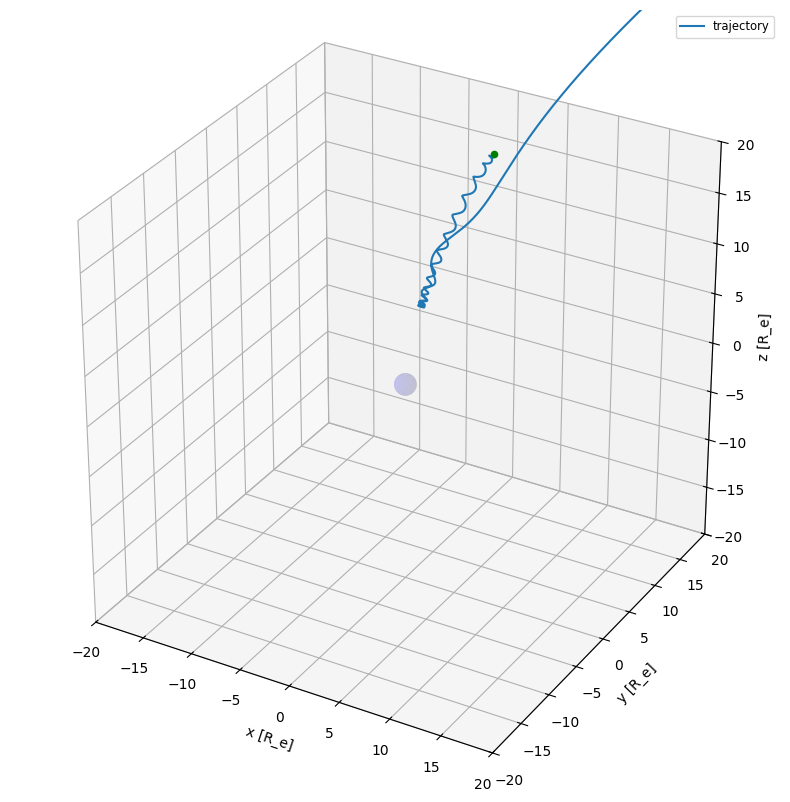

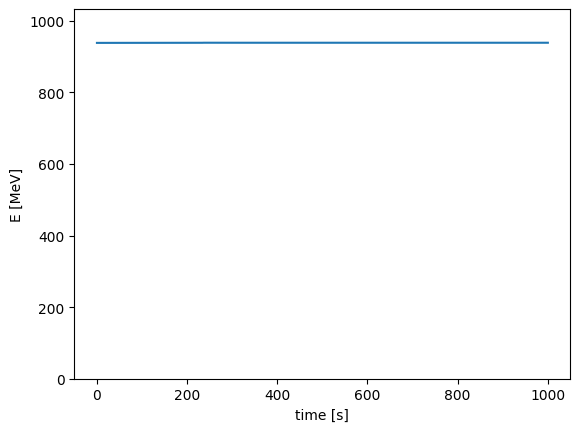

In [18]:
Y0 = particles[0]

## ODE integration
result = spi.solve_ivp(
    y_prime,
    t_span=TIME_RANGE,
    t_eval=t,
    y0=Y0,
    args=(dipole_field,),
    atol=ABSOLUTE_TOLERANCE,
    )

t_int = result.t
y_int = result.y

if DEBUG:
    print(f"Got result: {y_int.shape}")
    print(y_int[:, 0])
    print(y_int[:, 1])
    print(f"Took {result.nfev} function evaluations")

plot_trajectory([y_int[:3, :]], ["trajectory"], show_earth=True, r_e_limit=20)

## Let's also plot the energy of the particle
v_vec = y_int[3:, :] * u.m / u.s
E_sr = (MASS * c.c**2)**2 + (MASS * np.linalg.norm(v_vec, axis=0) * c.c)**2
E = np.sqrt(E_sr).to(u.megaelectronvolt)
plt.figure()
plt.plot(t_int, E)
plt.xlabel("time [s]")
plt.ylabel(f"E [{E.unit}]")
# Put the variation of the energy in context
plt.ylim(0, 1.1 * np.max(E.value))
plt.show()


## NOTE: not sure how good that is in terms of stability
## Paper suggests going up to sixth order RK

=> Most particles are boring, repeating this for every incoming particle is not feasible!


#### Backtracking
We can also track the particle **backward in time**, from a confirmed detection (eg. AMS).

=> modify the EOM to track the particle backward in time


### Backwards tracking - flipping the ODE

In [8]:
def check_trajectory(trajectory: np.ndarray) -> str:
    if DEBUG:
        print(f"trajectory shape = {trajectory.shape}")
        print(f"norm shape = {np.linalg.norm(trajectory, axis=0).shape}")
        print(f"earth condition: {np.linalg.norm(trajectory, axis=0) < c.R_earth.to(u.m).value}")

    r = np.linalg.norm(trajectory, axis=0)
    # check if it intersects the earth
    if np.any(r < c.R_earth.to(u.m).value):
        return "Intersects the earth"
    
    # check if it goes too far
    if any(r > 5 * c.R_earth.to(u.m).value):
        return "Leaves 5R_e"

    return "Too short"


def clip_trajectory(trajectory: np.ndarray) -> np.ndarray:
    r = np.linalg.norm(trajectory, axis=0)
    idx = np.where(r < c.R_earth.to(u.m).value)[0]
    if len(idx) == 0:
        return trajectory
    print(f"Clipping at index {idx[0]}")
    return trajectory[:, :idx[0]]

In [9]:
def multi_tracking(
        b_field_function: callable,
        # either we explicitly set the initial conditions
        y_0: list[np.ndarray] = None,
        # or we generate them randomly
        x_0_val: float = 7e6, # close to the earth
        v_0_val: float = energy_to_speed(5 * u.megaelectronvolt),
        seed: int = None,
        repetitions: int = 1,
        time_range: list = [0, 50],
        n_steps: int = 10000,
        do_clip_trajectory: bool = False,
        write_to_file: bool = False,
):
    if seed:
        np.random.seed(seed)

    if y_0 is None:
        y_0 = []
        print(f"Using random initial conditions with x_0 = {x_0_val:.2E} and v_0 = {v_0_val:.2E}")
        for _ in range(repetitions):
            x = np.random.rand(3) * 2 - 1 # random vector in [-1, 1]
            x = x / np.linalg.norm(x) * x_0_val
            v = np.random.rand(3) * 2 - 1 # random vector in [-1, 1]
            v = v / np.linalg.norm(v) * v_0_val.to(u.m / u.s).value
            y = np.concatenate((x, v))
            y_0.append(y)


    trajectories = []
    labels = []
    for Y0 in y_0:
        if DEBUG:
            print(f"X_0 = {Y0[3:]}, |X_0| = {np.linalg.norm(Y0[3:]):.2E}")
            print(f"V_0 = {Y0[:3]}, |V_0| = {np.linalg.norm(Y0[:3]):.2E}")
        
        t = np.linspace(time_range[0], time_range[1], n_steps)
        sol = spi.solve_ivp(
            lambda t, y: -y_prime(-t, y, b_field_function), # formulate the problem backward
            t_span = [time_range[1], time_range[0]],
            t_eval= t[::-1],
            y0 = Y0,
            method='RK45',
            atol=ABSOLUTE_TOLERANCE
        )
        traj = sol.y[:3, :]

        check = check_trajectory(traj)
        if do_clip_trajectory and "Intersects" in check:
            traj = clip_trajectory(traj)

        trajectories.append(traj)
        labels.append(check)

    plot_trajectory(trajectories, labels, show_earth=True, r_e_limit=5)


In [10]:
### CAUTION:
## From here on code runs are long, are you sure you want to run them?
raise Exception("Code below this line is not meant to be run by default")

Exception: Code below this line is not meant to be run by default

v = 401509301.9697915 m / s > c, setting 1/gamma = 0
v = 1109630037.104217 m / s > c, setting 1/gamma = 0
v = 1006107554.7075177 m / s > c, setting 1/gamma = 0
v = 372392197.88407 m / s > c, setting 1/gamma = 0
v = 319756456.8269802 m / s > c, setting 1/gamma = 0
v = 1630319657.1509094 m / s > c, setting 1/gamma = 0
v = 1950681824.6525087 m / s > c, setting 1/gamma = 0
v = 316746739.4509241 m / s > c, setting 1/gamma = 0
v = 322028770.69581443 m / s > c, setting 1/gamma = 0
Clipping at index 2


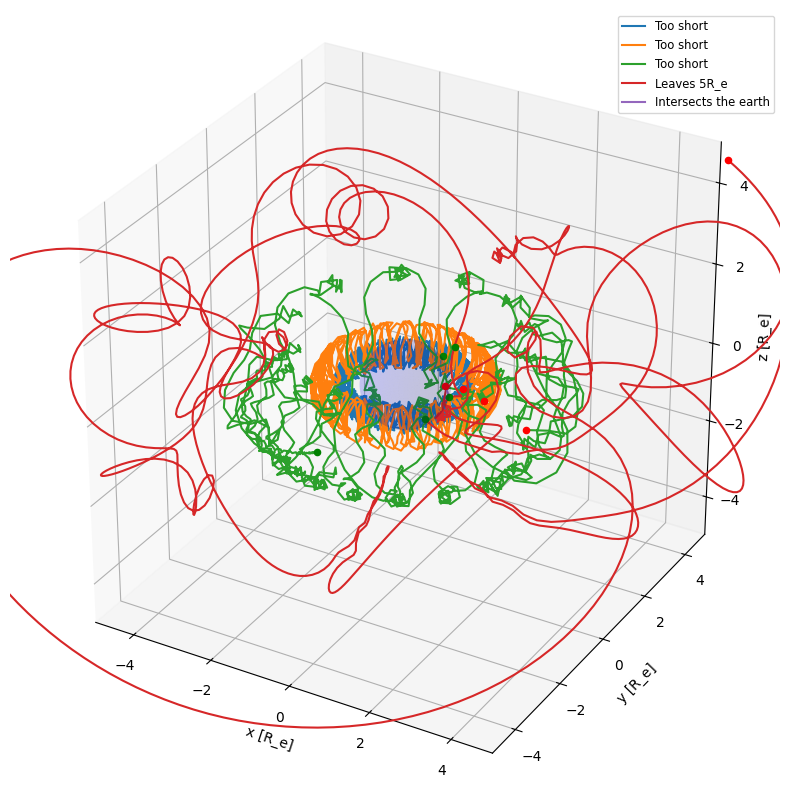

In [ ]:
## Some nice specific examples
Y = []

# small shell around the earth
X0 = np.array([3.8e6, 3.8e6, 3.8e6])
V0 = np.array([0, -5e5, -2e6])
Y0 = np.concatenate((X0, V0))
Y.append(Y0)

# medium shell around the earth
X0 = np.array([5e6, 5e6, 5e6])
V0 = np.array([0, -5e5, -1e6])
Y0 = np.concatenate((X0, V0))
Y.append(Y0)

# large+stable shell around the earth
X0 = np.array([-9e6, -9e6, -9e6])
V0 = np.array([0, -1e6, 1e6])
Y0 = np.concatenate((X0, V0))
Y.append(Y0)

# large+instable shell around the earth
X0 = np.array([2e6, 2e6, -6e6])
V0 = np.array([1e4, 1e4, -1e3])
Y0 = np.concatenate((X0, V0))
Y.append(Y0)

# particle leaves rather quickly
X0 = np.array([7e6, 0, 0])
V0 = np.array([0, -4e7, +4e7])
Y0 = np.concatenate((X0, V0))
Y.append(Y0)

multi_tracking(dipole_field, y_0=Y, time_range=[0, 50], n_steps=1000, do_clip_trajectory=True)

## NOTE: too short = particle does not leave earth within integration time
## probably originated from earth
## 0 bounce, 1 bounce ...

In [ ]:
"""
## Try the IGRF field
Y = []

# small shell around the earth
X0 = np.array([3.8e6, 3.8e6, 3.8e6])
V0 = np.array([0, -5e5, -2e6])
Y0 = np.concatenate((X0, V0))
Y.append(Y0)

DEBUG = False
multi_tracking(IGRF_field, y_0=Y, time_range=[0, 100], n_steps=10000, do_clip_trajectory=True)
"""

Using random initial conditions with x_0 = 7.00E+06 and v_0 = 3.08E+07 m / s
Clipping at index 1
Clipping at index 2
Clipping at index 4
Clipping at index 3


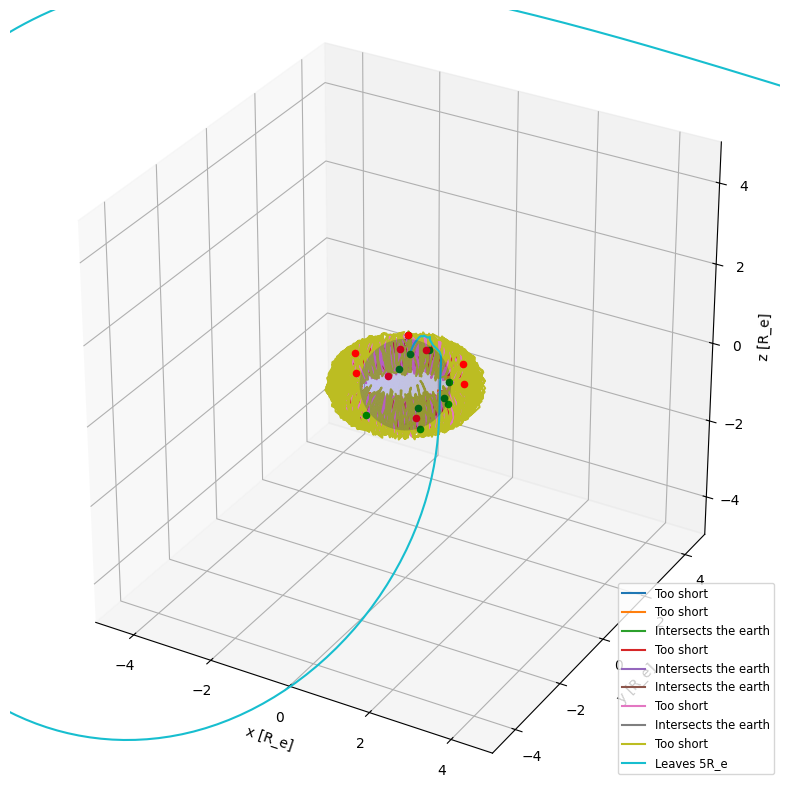

In [19]:
multi_tracking(
    b_field_function = dipole_field,
    x_0_val = 7e6,
    v_0_val = energy_to_speed(5 * u.megaelectronvolt),
    # seed = 234982,
    repetitions = 10,
    time_range = [0, 50],
    n_steps = 1000,
    do_clip_trajectory = True,
)


Using random initial conditions with x_0 = 8.00E+06 and v_0 = 4.34E+07 m / s
Clipping at index 2
Clipping at index 679
v = 779440810.7986486 m / s > c, setting 1/gamma = 0
v = 749609948.3930267 m / s > c, setting 1/gamma = 0
v = 400922601.3320647 m / s > c, setting 1/gamma = 0
Clipping at index 2
v = 576932655.9303913 m / s > c, setting 1/gamma = 0
v = 648279219.6509187 m / s > c, setting 1/gamma = 0
Clipping at index 12
v = 304182251.7287902 m / s > c, setting 1/gamma = 0
Clipping at index 12


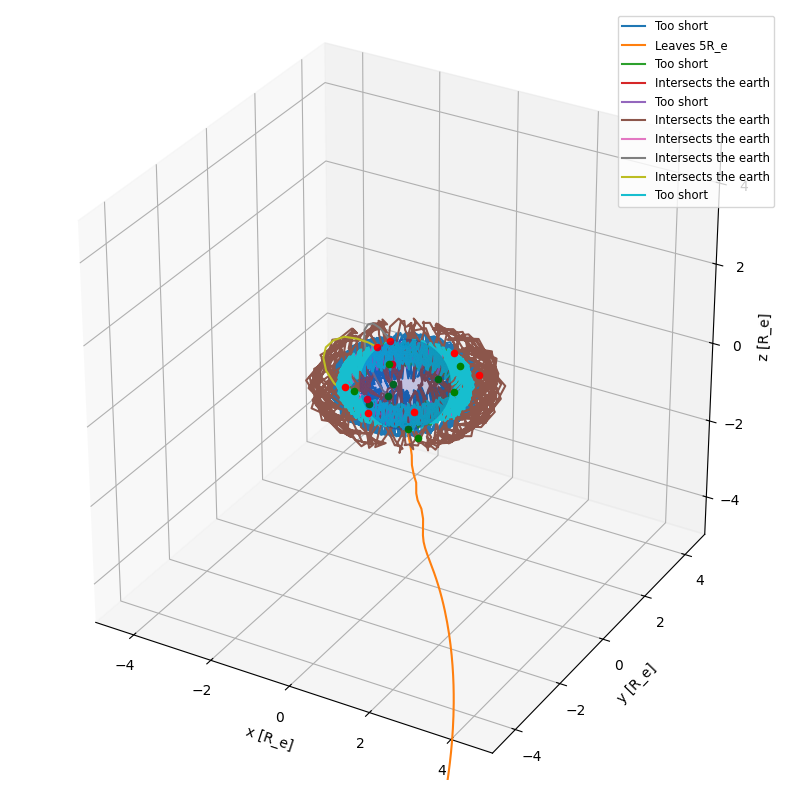

In [ ]:
multi_tracking(
    b_field_function = dipole_field,
    x_0_val = 8e6,
    v_0_val = energy_to_speed(10 * u.megaelectronvolt),
    # seed = 234982,
    repetitions = 10,
    time_range = [0, 50],
    n_steps = 1000,
    do_clip_trajectory = True,
)


Using random initial conditions with x_0 = 8.00E+06 and v_0 = 2.62E+08 m / s
v = 407089765.0224745 m / s > c, setting 1/gamma = 0
v = 396666612.97455454 m / s > c, setting 1/gamma = 0
v = 304812903.49223787 m / s > c, setting 1/gamma = 0
v = 300968987.60080004 m / s > c, setting 1/gamma = 0
v = 301991659.5490343 m / s > c, setting 1/gamma = 0
v = 299910646.40722656 m / s > c, setting 1/gamma = 0
v = 302400000.83455276 m / s > c, setting 1/gamma = 0
v = 305408779.8569856 m / s > c, setting 1/gamma = 0
v = 303887248.9210842 m / s > c, setting 1/gamma = 0
v = 302753682.1200956 m / s > c, setting 1/gamma = 0
v = 300360851.27158624 m / s > c, setting 1/gamma = 0
v = 469708691.8234606 m / s > c, setting 1/gamma = 0
v = 484489864.5405244 m / s > c, setting 1/gamma = 0
v = 314472878.7284921 m / s > c, setting 1/gamma = 0
v = 363090455.3429083 m / s > c, setting 1/gamma = 0
v = 308927987.86436754 m / s > c, setting 1/gamma = 0
v = 312542260.0732034 m / s > c, setting 1/gamma = 0
v = 371630140.6

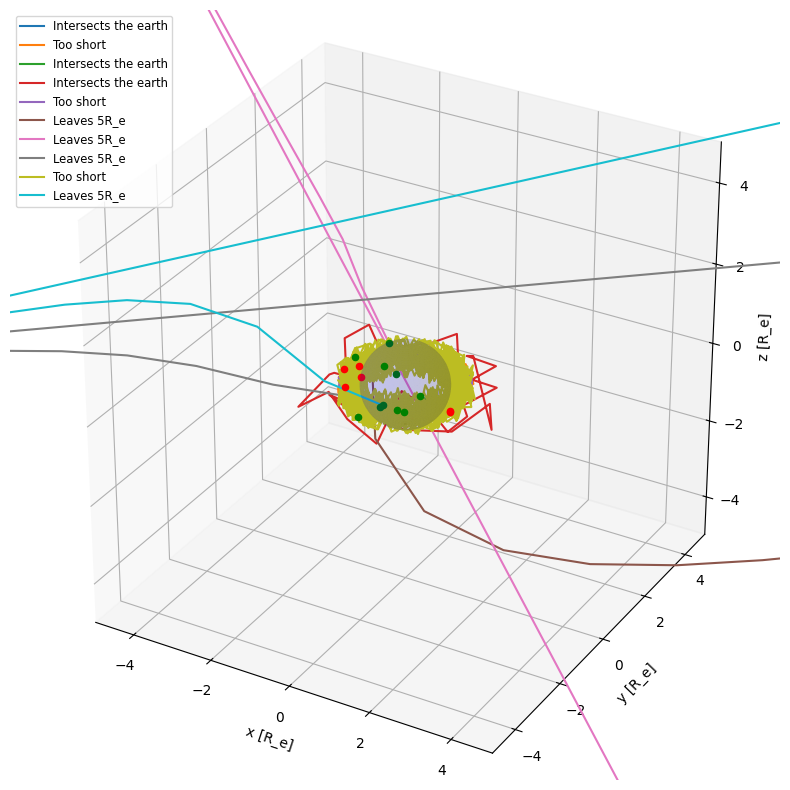

In [ ]:
# note how numerical stability becomes an issue
multi_tracking(
    b_field_function = dipole_field,
    x_0_val = 8e6,
    v_0_val = energy_to_speed(1 * u.gigaelectronvolt),
    # seed = 234982,
    repetitions = 10,
    time_range = [0, 50],
    n_steps = 1000,
    do_clip_trajectory = True,
)


Using random initial conditions with x_0 = 8.00E+06 and v_0 = 2.84E+08 m / s
v = 299843887.3881295 m / s > c, setting 1/gamma = 0
v = 303194720.0489516 m / s > c, setting 1/gamma = 0
v = 305168938.3069865 m / s > c, setting 1/gamma = 0
v = 330891534.73528314 m / s > c, setting 1/gamma = 0
v = 327380463.5318737 m / s > c, setting 1/gamma = 0
v = 353487508.6116693 m / s > c, setting 1/gamma = 0
v = 345481765.9038232 m / s > c, setting 1/gamma = 0
v = 301081227.99370396 m / s > c, setting 1/gamma = 0
v = 304143871.8855445 m / s > c, setting 1/gamma = 0
v = 308886238.9254942 m / s > c, setting 1/gamma = 0
v = 312596192.31716526 m / s > c, setting 1/gamma = 0
v = 303704435.0744467 m / s > c, setting 1/gamma = 0
v = 307198932.872008 m / s > c, setting 1/gamma = 0
v = 324952004.3864175 m / s > c, setting 1/gamma = 0
v = 327999579.3720159 m / s > c, setting 1/gamma = 0
v = 342383649.4199299 m / s > c, setting 1/gamma = 0
v = 339256547.4348202 m / s > c, setting 1/gamma = 0
v = 318420461.022558

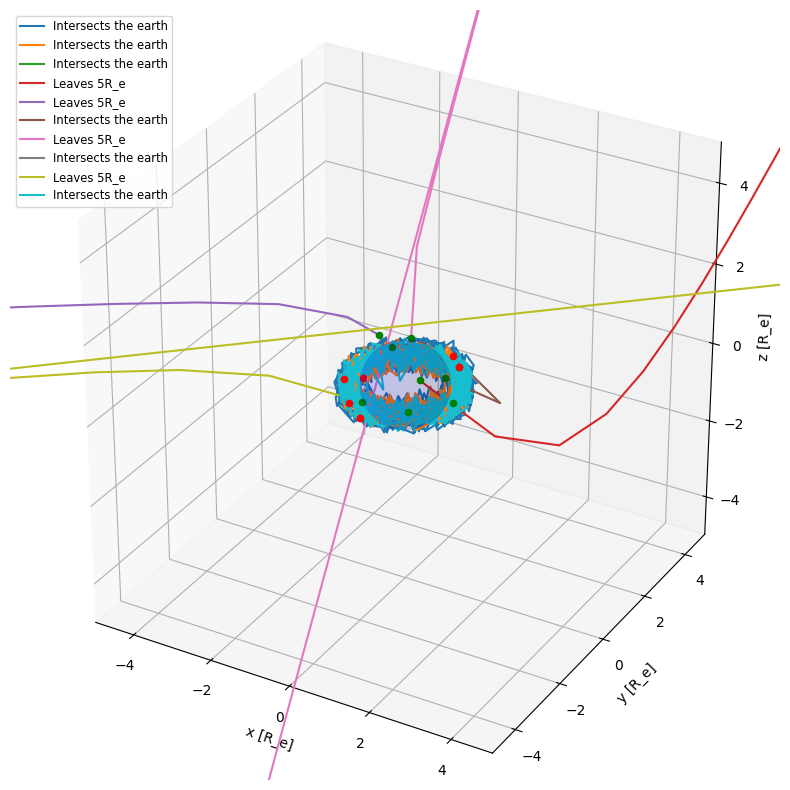

In [ ]:
multi_tracking(
    b_field_function = dipole_field,
    x_0_val = 8e6,
    v_0_val = energy_to_speed(2 * u.gigaelectronvolt),
    # seed = 234982,
    repetitions = 10,
    time_range = [0, 50],
    n_steps = 1000,
    do_clip_trajectory = True,
)

### Doing statistics
Following the paper by Smart et al.: https://doi.org/10.1016/j.asr.2004.09.015

#### Naively computing the geomagnetic cutoff:
- backtrack particles to determine whether they are of atmospheric or cosmic origin
- repeat for a range of energies
- recover the **Störmer Formula** for energy thresholds 
- identify the **penumbra** of the geomagnetic cutoff

#### More sophistication
- distinguish positions and angles
- use better field models
- enforce numerical stability

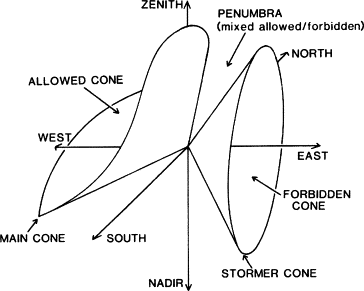

### Appendix - coordinate systems
The IGRF is usually computed in *geodetic* coordinates: the Earth is an ellipse and the coordinate axis follow the ellipsoid. 

To simplify the computation, we will use *geocentric* coordinates where we consider the Earth as a sphere.

In the following we will express vectors in the following 3D coordinate system:
- the origin is the center of the Earth
- r is given in km
- theta is given in degrees (corresponds to colatitudes) -> -90 to 90
- phi is given in degrees (corresponds to longitudes) -> -180 to 180


In [ ]:
## Example - the spherical earth
# generate a grid of points that correspond to the surface of the earth
n = 15
lat_range = np.linspace(-90, 90, 2*n)
lon_range = np.linspace(-180, 180, n)
lat, lon = np.meshgrid(lat_range, lon_range)
lat = lat.flatten()
lon = lon.flatten()

# map to cartesian coordinates for plotting
r = 6.4e3
x = r * np.cos(np.radians(lat)) * np.cos(np.radians(lon))
y = r * np.cos(np.radians(lat)) * np.sin(np.radians(lon))
z = r * np.sin(np.radians(lat))

# plot the grid
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect([1,1,1])
ax.scatter(x, y, z)
plt.show()